<a href="https://colab.research.google.com/github/armen1s/BOT/blob/main/Panic_Tr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2497251811.py:168: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download('BTC-USD', period='2y', interval='1h', progress=False)



--- Training on 4H Data ---
Epoch 1: 2.1127
Epoch 2: 1.9599
Epoch 3: 1.9150
Epoch 4: 1.8719
Epoch 5: 1.8527
Epoch 6: 1.8043
Epoch 7: 1.7844
Epoch 8: 1.7646
Epoch 9: 1.7846
Epoch 10: 1.7322
Epoch 11: 1.7240
Epoch 12: 1.6952
Epoch 13: 1.7078
Epoch 14: 1.6774
Epoch 15: 1.6960

--- Running 4H Straddle Backtest ---
Trades: 172
Final Return: 0.43%


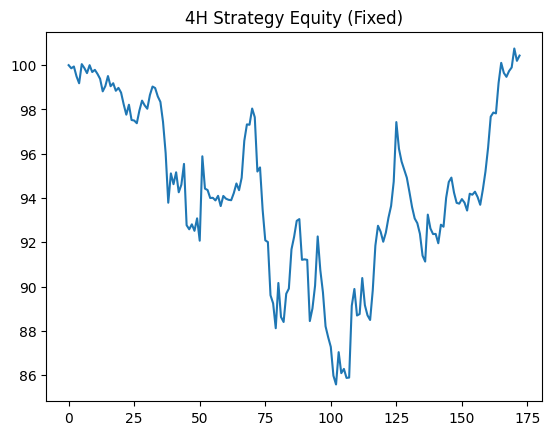

In [4]:
# --- FINAL CELL: 4H Timeframe Strategy Pivot (REFINED) ---

# 1. IMPORTS & CONFIG
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrizations as parametrizations
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    SEQ_LEN = 64           # Окно контекста
    INPUT_DIM = 8          # 8 каналов
    LATENT_DIM = 64
    ATTN_HEADS = 4
    PROJ_DIM = 32
    BATCH_SIZE = 32
    LR = 2e-4
    MARGIN = 2.0

config = Config()

# 2. MODEL
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv1 = parametrizations.weight_norm(conv1)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.Mish()
        self.dropout1 = nn.Dropout(dropout)
        conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv2 = parametrizations.weight_norm(conv2)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.Mish()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.Mish()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:x.size(0), :]

class DeepAlpha4H(nn.Module):
    def __init__(self, num_inputs=8):
        super(DeepAlpha4H, self).__init__()
        self.tcn = nn.Sequential(
            TemporalBlock(num_inputs, 32, 3, 1, 1, 2, 0.2),
            TemporalBlock(32, 64, 3, 1, 2, 4, 0.2),
            TemporalBlock(64, 64, 3, 1, 4, 8, 0.2),
            TemporalBlock(64, 128, 3, 1, 8, 16, 0.2)
        )
        self.dim = 128
        self.pos_encoder = PositionalEncoding(self.dim, config.SEQ_LEN)
        self.attn = nn.MultiheadAttention(self.dim, config.ATTN_HEADS, dropout=0.2)
        self.norm = nn.LayerNorm(self.dim)

        self.head_cont = nn.Linear(self.dim, config.PROJ_DIM)
        self.head_trade = nn.Sequential(nn.Linear(self.dim, 32), nn.Mish(), nn.Linear(32, 1))
        self.head_vis = nn.Sequential(nn.Linear(128, 16), nn.Tanh(), nn.Linear(16, 2))

    # FIX: Causal Attention Mask
    def generate_causal_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)

    def forward(self, x):
        tcn_out = self.tcn(x)
        perm = tcn_out.permute(2, 0, 1)
        perm = self.pos_encoder(perm)

        # FIX: Применение маски
        mask = self.generate_causal_mask(perm.size(0))
        attn_out, _ = self.attn(perm, perm, perm, attn_mask=mask)

        attn_out = self.norm(attn_out + perm)
        ctx = attn_out[-1]

        z_proj = F.normalize(self.head_cont(ctx), p=2, dim=1)
        logits = self.head_trade(ctx)
        vis = self.head_vis(ctx)
        return z_proj, logits, vis

class MarginLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, z, logits, y, w):
        dist = torch.cdist(z, z, p=2)
        labels = y.view(-1, 1)
        pos_mask = torch.eq(labels, labels.T).float() - torch.eye(len(y)).to(y.device)
        neg_mask = 1 - torch.eq(labels, labels.T).float()

        pos_loss = (dist**2) * pos_mask
        neg_loss = (torch.clamp(self.margin - dist, min=0)**2) * neg_mask

        cont_loss = (pos_loss.sum() + neg_loss.sum()) / (pos_mask.sum() + neg_mask.sum() + 1e-6)
        trade_loss = (self.bce(logits, y) * w).mean()
        return cont_loss + trade_loss

# 3. DATA ENGINE
class DataEngine:
    @staticmethod
    def process(df):
        rng = (df['High'] - df['Low']) + 1e-6
        df['P_Press'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / rng
        df['P_Eff'] = np.abs(df['Close'] - df['Open']) / rng

        v_log = np.log(df['Volume'] + 1)
        v_z = (v_log - v_log.rolling(24).mean()) / (v_log.rolling(24).std() + 1e-6)
        df['Vol_Norm'] = np.tanh(v_z)

        pc = df['Close'].diff()
        pc_z = (pc - pc.rolling(24).mean()) / (pc.rolling(24).std() + 1e-6)
        df['P_Vel'] = (pc_z * (df['Vol_Norm']*0.5 + 1)).clip(-5, 5)

        cols = []
        for c in ['Open', 'High', 'Low', 'Close']:
            df[f'{c}_Log'] = np.log(df[c])
            fd = df[f'{c}_Log'].diff()
            norm = (fd - fd.rolling(100).mean()) / (fd.rolling(100).std() + 1e-6)
            # FIX: Tanh-нормализация
            df[f'{c}_Norm'] = np.tanh(norm)
            cols.append(f'{c}_Norm')

        final_cols = cols + ['Vol_Norm', 'P_Press', 'P_Eff', 'P_Vel']
        df = df.dropna()

        tr = df['High'] - df['Low']
        atr = tr.rolling(24).mean()
        future_vol = tr.shift(-1)

        labels = (future_vol > atr * 1.3).astype(float)
        weights = (future_vol / (atr + 1e-6)).clip(1, 3)

        return df[final_cols].values[:-1], labels.values[:-1], weights.values[:-1], df.iloc[:-1]

# 4. EXECUTION PIPELINE
print("Downloading 1H data and Resampling to 4H...")
df_raw = yf.download('BTC-USD', period='2y', interval='1h', progress=False)
if isinstance(df_raw.columns, pd.MultiIndex): df_raw.columns = df_raw.columns.droplevel(1)

agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}
df_4h = df_raw.resample('4h').agg(agg_dict).dropna()

feats, y, w, df_clean = DataEngine.process(df_4h)
split = int(len(feats) * 0.8)

class Ds(Dataset):
    def __init__(self, f, y, w):
        self.f, self.y, self.w = torch.FloatTensor(f).permute(1,0), torch.FloatTensor(y).unsqueeze(1), torch.FloatTensor(w).unsqueeze(1)
    def __len__(self): return self.f.shape[1] - config.SEQ_LEN
    def __getitem__(self, i): return self.f[:, i:i+config.SEQ_LEN], self.y[i+config.SEQ_LEN-1], self.w[i+config.SEQ_LEN-1]

# FIX: Исправленная реализация Weighted Sampling (для окон)
train_dataset = Ds(feats[:split], y[:split], w[:split])

# Собираем метки именно для доступных окон
window_labels = []
for i in range(len(train_dataset)):
    _, label, _ = train_dataset[i]
    window_labels.append(int(label.item()))

class_counts = np.bincount(window_labels)
class_weights = 1. / class_counts
sample_weights = [class_weights[l] for l in window_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

train_dl = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, sampler=sampler, drop_last=True)
test_dl = DataLoader(Ds(feats[split:], y[split:], w[split:]), batch_size=config.BATCH_SIZE, shuffle=False)

model = DeepAlpha4H(config.INPUT_DIM).to(device)
opt = optim.AdamW(model.parameters(), lr=config.LR)
crit = MarginLoss(config.MARGIN)

print("\n--- Training on 4H Data ---")
for ep in range(15):
    model.train()
    loss_acc = 0
    for xb, yb, wb in train_dl:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
        opt.zero_grad()
        z, l, v = model(xb)
        loss = crit(z, l, yb, wb)
        loss.backward()
        opt.step()
        loss_acc += loss.item()
    print(f"Epoch {ep+1}: {loss_acc/len(train_dl):.4f}")

# 5. FINAL BACKTEST
print("\n--- Running 4H Straddle Backtest ---")
model.eval()
preds = []
with torch.no_grad():
    full_ds = Ds(feats[split:], y[split:], w[split:])
    for i in range(len(full_ds)):
        xb, _, _ = full_ds[i]
        _, logits, _ = model(xb.unsqueeze(0).to(device))
        preds.append(torch.sigmoid(logits).item())

equity = [100.0]
trades = []
threshold = 0.80

real_split_idx = split + config.SEQ_LEN - 1

for i, prob in enumerate(preds):
    curr_idx = real_split_idx + i
    if curr_idx + 1 >= len(df_clean): break

    curr = df_clean.iloc[curr_idx]
    next_bar = df_clean.iloc[curr_idx+1]

    if prob > threshold:
        # Check Long
        if next_bar['High'] > curr['High']:
            res = (next_bar['Close'] - curr['High']) / curr['High']
            equity.append(equity[-1] * (1 + res - 0.001))
            trades.append(res)
        # Check Short
        elif next_bar['Low'] < curr['Low']:
            res = (curr['Low'] - next_bar['Close']) / curr['Low']
            equity.append(equity[-1] * (1 + res - 0.001))
            trades.append(res)

if len(trades) > 0:
    print(f"Trades: {len(trades)}")
    print(f"Final Return: {equity[-1] - 100:.2f}%")
    plt.plot(equity)
    plt.title("4H Strategy Equity (Fixed)")
    plt.show()
else:
    print("No trades. Lower threshold.")

--- DIAGNOSTICS ---


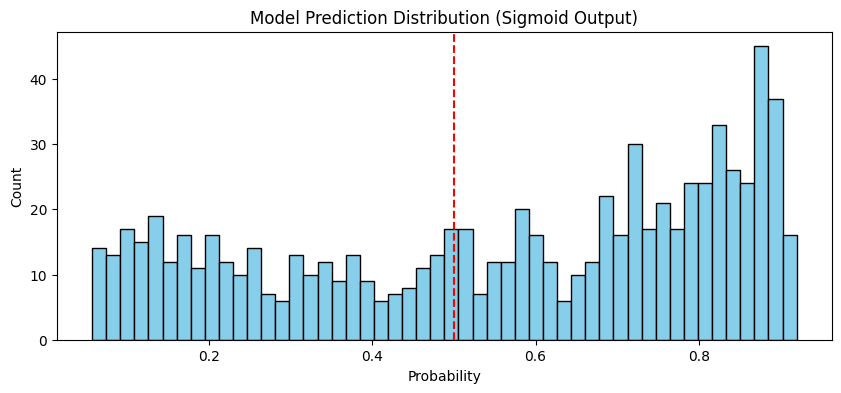

Min Prob: 0.0574
Max Prob: 0.9196
Mean Prob: 0.5592

--- THRESHOLD GRID SEARCH ---
Thresh 0.50 | Trades: 407 | WinRate: 47.4% | Return: 8.48%
Thresh 0.55 | Trades: 382 | WinRate: 47.6% | Return: 8.15%
Thresh 0.60 | Trades: 344 | WinRate: 46.5% | Return: 3.90%
Thresh 0.65 | Trades: 318 | WinRate: 46.9% | Return: 2.85%
Thresh 0.70 | Trades: 280 | WinRate: 45.7% | Return: -1.12%
Thresh 0.75 | Trades: 227 | WinRate: 42.7% | Return: -3.46%
------------------------------
RECOMMENDATION: Use Threshold = 0.50


In [5]:
# --- DIAGNOSTIC & TUNING CELL ---

print("--- DIAGNOSTICS ---")
# 1. Inspect Probability Distribution
plt.figure(figsize=(10, 4))
plt.hist(preds, bins=50, color='skyblue', edgecolor='black')
plt.title("Model Prediction Distribution (Sigmoid Output)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.axvline(0.5, color='red', linestyle='--')
plt.show()

print(f"Min Prob: {min(preds):.4f}")
print(f"Max Prob: {max(preds):.4f}")
print(f"Mean Prob: {np.mean(preds):.4f}")

# 2. Threshold Grid Search
print("\n--- THRESHOLD GRID SEARCH ---")
best_return = -999
best_thresh = 0

thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75]

for th in thresholds:
    equity = [100.0]
    trades_count = 0
    wins = 0

    # Fast Loop
    for i, prob in enumerate(preds):
        curr_idx = real_split_idx + i
        if curr_idx + 1 >= len(df_clean): break

        curr = df_clean.iloc[curr_idx]
        next_bar = df_clean.iloc[curr_idx+1]

        if prob > th:
            res = 0.0
            # Long
            if next_bar['High'] > curr['High']:
                res = (next_bar['Close'] - curr['High']) / curr['High']
            # Short
            elif next_bar['Low'] < curr['Low']:
                res = (curr['Low'] - next_bar['Close']) / curr['Low']

            # Если сделка была (ордер сработал)
            if res != 0.0:
                # Cost 0.1%
                pnl = res - 0.001
                equity.append(equity[-1] * (1 + pnl))
                trades_count += 1
                if pnl > 0: wins += 1

    total_ret = equity[-1] - 100
    win_rate = (wins / trades_count * 100) if trades_count > 0 else 0

    print(f"Thresh {th:.2f} | Trades: {trades_count} | WinRate: {win_rate:.1f}% | Return: {total_ret:.2f}%")

    if total_ret > best_return and trades_count > 10:
        best_return = total_ret
        best_thresh = th

print("-" * 30)
if best_thresh > 0:
    print(f"RECOMMENDATION: Use Threshold = {best_thresh:.2f}")
else:
    print("Model needs more epochs or higher LR (Underfitting).")

/tmp/ipython-input-3146899007.py:169: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download('BTC-USD', period='2y', interval='1h', progress=False)



--- Training on 4H Data ---
Epoch 1: 1.8040
Epoch 2: 1.7489
Epoch 3: 1.7130
Epoch 4: 1.6670
Epoch 5: 1.6429
Epoch 6: 1.6285
Epoch 7: 1.6147
Epoch 8: 1.6038
Epoch 9: 1.5923
Epoch 10: 1.5751
Epoch 11: 1.5656
Epoch 12: 1.5524
Epoch 13: 1.5379
Epoch 14: 1.5087
Epoch 15: 1.5006

--- Running 4H Straddle Backtest ---
Trades: 8
Final Return: 1.15%


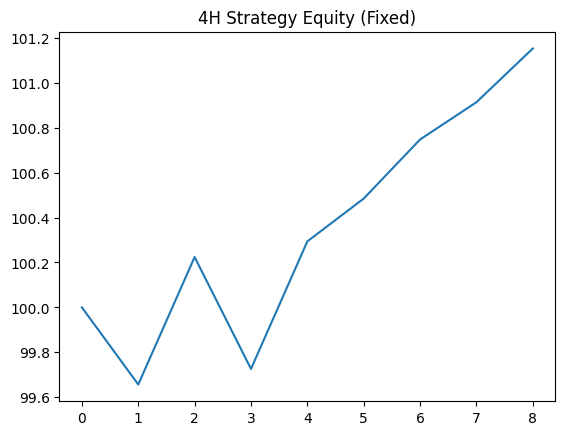

In [6]:

# --- FINAL CELL: 4H Timeframe Strategy Pivot (REFINED) ---

# 1. IMPORTS & CONFIG
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.parametrizations as parametrizations
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Config:
    SEQ_LEN = 64           # Уменьшаем окно (64 * 4ч = 10 дней контекста)
    INPUT_DIM = 8          # Те же 8 каналов
    LATENT_DIM = 64        # Увеличим мозг
    ATTN_HEADS = 4
    PROJ_DIM = 32
    BATCH_SIZE = 32        # Меньше батч для лучшей сходимости
    LR = 2e-4
    MARGIN = 2.0           # Жестче разделение

config = Config()

# 2. MODEL
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x): return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv1 = parametrizations.weight_norm(conv1)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.Mish()
        self.dropout1 = nn.Dropout(dropout)
        conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.conv2 = parametrizations.weight_norm(conv2)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.Mish()
        self.dropout2 = nn.Dropout(dropout)
        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.Mish()
    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)
    def forward(self, x): return x + self.pe[:x.size(0), :]

class DeepAlpha4H(nn.Module):
    def __init__(self, num_inputs=8):
        super(DeepAlpha4H, self).__init__()
        self.tcn = nn.Sequential(
            TemporalBlock(num_inputs, 32, 3, 1, 1, 2, 0.2),
            TemporalBlock(32, 64, 3, 1, 2, 4, 0.2),
            TemporalBlock(64, 64, 3, 1, 4, 8, 0.2),
            TemporalBlock(64, 128, 3, 1, 8, 16, 0.2)
        )
        self.dim = 128
        self.pos_encoder = PositionalEncoding(self.dim, config.SEQ_LEN)
        self.attn = nn.MultiheadAttention(self.dim, config.ATTN_HEADS, dropout=0.2)
        self.norm = nn.LayerNorm(self.dim)

        self.head_cont = nn.Linear(self.dim, config.PROJ_DIM)
        self.head_trade = nn.Sequential(nn.Linear(self.dim, 32), nn.Mish(), nn.Linear(32, 1))
        self.head_vis = nn.Sequential(nn.Linear(128, 16), nn.Tanh(), nn.Linear(16, 2))

    # FIX: Каузальная маска
    def generate_causal_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)

    def forward(self, x):
        tcn_out = self.tcn(x)
        perm = tcn_out.permute(2, 0, 1)
        perm = self.pos_encoder(perm)

        # FIX: Применение маски внимания
        mask = self.generate_causal_mask(perm.size(0))
        attn_out, _ = self.attn(perm, perm, perm, attn_mask=mask)

        attn_out = self.norm(attn_out + perm)
        ctx = attn_out[-1]

        z_proj = F.normalize(self.head_cont(ctx), p=2, dim=1)
        logits = self.head_trade(ctx)
        vis = self.head_vis(ctx)
        return z_proj, logits, vis

class MarginLoss(nn.Module):
    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, z, logits, y, w):
        dist = torch.cdist(z, z, p=2)
        labels = y.view(-1, 1)
        pos_mask = torch.eq(labels, labels.T).float() - torch.eye(len(y)).to(y.device)
        neg_mask = 1 - torch.eq(labels, labels.T).float()

        pos_loss = (dist**2) * pos_mask
        neg_loss = (torch.clamp(self.margin - dist, min=0)**2) * neg_mask

        cont_loss = (pos_loss.sum() + neg_loss.sum()) / (pos_mask.sum() + neg_mask.sum() + 1e-6)
        trade_loss = (self.bce(logits, y) * w).mean()
        return cont_loss + trade_loss

# 3. DATA ENGINE
class DataEngine:
    @staticmethod
    def process(df):
        # Physics
        rng = (df['High'] - df['Low']) + 1e-6
        df['P_Press'] = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / rng
        df['P_Eff'] = np.abs(df['Close'] - df['Open']) / rng

        v_log = np.log(df['Volume'] + 1)
        v_z = (v_log - v_log.rolling(24).mean()) / (v_log.rolling(24).std() + 1e-6)
        df['Vol_Norm'] = np.tanh(v_z)

        pc = df['Close'].diff()
        pc_z = (pc - pc.rolling(24).mean()) / (pc.rolling(24).std() + 1e-6)
        df['P_Vel'] = (pc_z * (df['Vol_Norm']*0.5 + 1)).clip(-5, 5)

        cols = []
        for c in ['Open', 'High', 'Low', 'Close']:
            df[f'{c}_Log'] = np.log(df[c])
            fd = df[f'{c}_Log'].diff()
            norm = (fd - fd.rolling(100).mean()) / (fd.rolling(100).std() + 1e-6)
            # FIX: Tanh нормализация
            df[f'{c}_Norm'] = np.tanh(norm)
            cols.append(f'{c}_Norm')

        final_cols = cols + ['Vol_Norm', 'P_Press', 'P_Eff', 'P_Vel']
        df = df.dropna()

        # Labels
        tr = df['High'] - df['Low']
        atr = tr.rolling(24).mean()
        future_vol = tr.shift(-1)
        labels = (future_vol > atr * 1.3).astype(float)
        weights = (future_vol / (atr + 1e-6)).clip(1, 3)

        return df[final_cols].values[:-1], labels.values[:-1], weights.values[:-1], df.iloc[:-1]

# 4. EXECUTION LOOP
print("Downloading 1H data and Resampling to 4H...")
df_raw = yf.download('BTC-USD', period='2y', interval='1h', progress=False)
if isinstance(df_raw.columns, pd.MultiIndex): df_raw.columns = df_raw.columns.droplevel(1)

agg_dict = {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'}
df_4h = df_raw.resample('4h').agg(agg_dict).dropna()

feats, y, w, df_clean = DataEngine.process(df_4h)
split = int(len(feats) * 0.8)

class Ds(Dataset):
    def __init__(self, f, y, w):
        self.f, self.y, self.w = torch.FloatTensor(f).permute(1,0), torch.FloatTensor(y).unsqueeze(1), torch.FloatTensor(w).unsqueeze(1)
    def __len__(self): return self.f.shape[1] - config.SEQ_LEN
    def __getitem__(self, i): return self.f[:, i:i+config.SEQ_LEN], self.y[i+config.SEQ_LEN-1], self.w[i+config.SEQ_LEN-1]

# Вернули обычный Shuffle без Sampler
train_dl = DataLoader(Ds(feats[:split], y[:split], w[:split]), batch_size=config.BATCH_SIZE, shuffle=True, drop_last=True)
test_dl = DataLoader(Ds(feats[split:], y[split:], w[split:]), batch_size=config.BATCH_SIZE, shuffle=False)

model = DeepAlpha4H(config.INPUT_DIM).to(device)
opt = optim.AdamW(model.parameters(), lr=config.LR)
crit = MarginLoss(config.MARGIN)

print("\n--- Training on 4H Data ---")
for ep in range(15):
    model.train()
    loss_acc = 0
    for xb, yb, wb in train_dl:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
        opt.zero_grad()
        z, l, v = model(xb)
        loss = crit(z, l, yb, wb)
        loss.backward()
        opt.step()
        loss_acc += loss.item()
    print(f"Epoch {ep+1}: {loss_acc/len(train_dl):.4f}")

# 5. FINAL BACKTEST
print("\n--- Running 4H Straddle Backtest ---")
model.eval()
preds = []
with torch.no_grad():
    full_ds = Ds(feats[split:], y[split:], w[split:])
    for i in range(len(full_ds)):
        xb, _, _ = full_ds[i]
        _, logits, _ = model(xb.unsqueeze(0).to(device))
        preds.append(torch.sigmoid(logits).item())

equity = [100.0]
trades = []
threshold = 0.80

real_split_idx = split + config.SEQ_LEN - 1

for i, prob in enumerate(preds):
    curr_idx = real_split_idx + i
    if curr_idx + 1 >= len(df_clean): break

    curr = df_clean.iloc[curr_idx]
    next_bar = df_clean.iloc[curr_idx+1]

    if prob > threshold:
        if next_bar['High'] > curr['High']:
            res = (next_bar['Close'] - curr['High']) / curr['High']
            equity.append(equity[-1] * (1 + res - 0.001))
            trades.append(res)
        elif next_bar['Low'] < curr['Low']:
            res = (curr['Low'] - next_bar['Close']) / curr['Low']
            equity.append(equity[-1] * (1 + res - 0.001))
            trades.append(res)

if len(trades) > 0:
    print(f"Trades: {len(trades)}")
    print(f"Final Return: {equity[-1] - 100:.2f}%")
    plt.plot(equity)
    plt.title("4H Strategy Equity (Fixed)")
    plt.show()
else:
    print("No trades. Lower threshold.")

--- DIAGNOSTICS ---


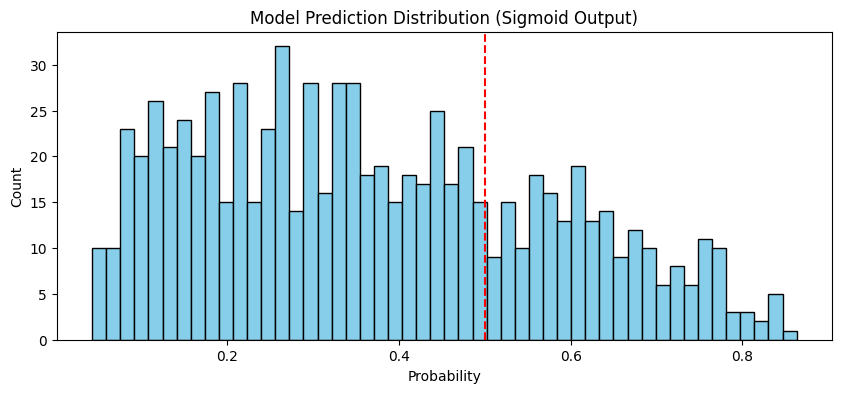

Min Prob: 0.0423
Max Prob: 0.8634
Mean Prob: 0.3721

--- THRESHOLD GRID SEARCH ---
Thresh 0.50 | Trades: 181 | WinRate: 45.9% | Return: 2.64%
Thresh 0.55 | Trades: 152 | WinRate: 44.7% | Return: 1.02%
Thresh 0.60 | Trades: 110 | WinRate: 46.4% | Return: 6.95%
Thresh 0.65 | Trades: 71 | WinRate: 49.3% | Return: 2.76%
Thresh 0.70 | Trades: 46 | WinRate: 56.5% | Return: 7.39%
Thresh 0.75 | Trades: 26 | WinRate: 65.4% | Return: 7.54%
------------------------------
RECOMMENDATION: Use Threshold = 0.75


In [7]:
# --- DIAGNOSTIC & TUNING CELL ---

print("--- DIAGNOSTICS ---")
# 1. Inspect Probability Distribution
plt.figure(figsize=(10, 4))
plt.hist(preds, bins=50, color='skyblue', edgecolor='black')
plt.title("Model Prediction Distribution (Sigmoid Output)")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.axvline(0.5, color='red', linestyle='--')
plt.show()

print(f"Min Prob: {min(preds):.4f}")
print(f"Max Prob: {max(preds):.4f}")
print(f"Mean Prob: {np.mean(preds):.4f}")

# 2. Threshold Grid Search
print("\n--- THRESHOLD GRID SEARCH ---")
best_return = -999
best_thresh = 0
thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75]

for th in thresholds:
    equity = [100.0]
    trades_count = 0
    wins = 0

    # Fast Loop
    for i, prob in enumerate(preds):
        curr_idx = real_split_idx + i
        if curr_idx + 1 >= len(df_clean): break

        curr = df_clean.iloc[curr_idx]
        next_bar = df_clean.iloc[curr_idx+1]

        if prob > th:
            res = 0.0
            # Long
            if next_bar['High'] > curr['High']:
                res = (next_bar['Close'] - curr['High']) / curr['High']
            # Short
            elif next_bar['Low'] < curr['Low']:
                res = (curr['Low'] - next_bar['Close']) / curr['Low']

            # Если сделка была (ордер сработал)
            if res != 0.0:
                # Cost 0.1%
                pnl = res - 0.001
                equity.append(equity[-1] * (1 + pnl))
                trades_count += 1
                if pnl > 0: wins += 1

    total_ret = equity[-1] - 100
    win_rate = (wins / trades_count * 100) if trades_count > 0 else 0

    print(f"Thresh {th:.2f} | Trades: {trades_count} | WinRate: {win_rate:.1f}% | Return: {total_ret:.2f}%")

    if total_ret > best_return and trades_count > 10:
        best_return = total_ret
        best_thresh = th

print("-" * 30)
if best_thresh > 0:
    print(f"RECOMMENDATION: Use Threshold = {best_thresh:.2f}")
else:
    print("Model needs more epochs or higher LR (Underfitting).")